# PyEarthScience:  Python examples for Earth Scientists

## unstructured data plots - ICON

### Using matplotlib

#### Polygon plot with
    - filled polygons (triangles)
    - labelbar (colorbar)
    - title
    
    It takes ~40 seconds.


In [11]:
import math, time, sys, os
import numpy as np
from   mpl_toolkits.basemap import Basemap
import matplotlib as mpl
import matplotlib.pyplot as plt
from   matplotlib.backends.backend_pdf import PdfPages
from   matplotlib.patches import Polygon
from   netCDF4 import Dataset as open_ncfile

Show plot in this notebook.

In [12]:
%matplotlib inline

Define path, grid, variable and title.

In [13]:
diri    = '/Users/k204045/NCL/PyNGL/User_Guide_examples/'   #-- data directory
fname   = 'ta_ps_850.nc'                            #-- data file
gname   = 'r2b4_amip.nc'                            #-- grid info file
VarName = 'ta'                                      #-- variable name       

#--  open data and grid file and read data and coordinate variable
f = open_ncfile(diri + fname,'r')                   #-- add data file
g = open_ncfile(diri + gname,'r')                   #-- add grid file (not contained in data file!!!)

#-- read first timestep and level of variable 'ta' 
variable =  f.variables['ta']                       #-- first time step, lev, ncells
var      =  variable[0,0,:]                         #-- ta [time,lev,ncells]
var      =  var - 273.15                            #-- convert to degrees Celsius

title    = 'Matplotlib: ICON model data'            #-- plot title string

Define _FillValue and missing_value if not existing.

In [14]:
missing = -1e20

if not hasattr(var,'_FillValue'):
   var._FillValue  =  missing                       #-- set _FillValue
if not hasattr(var,'missing_value'): 
   var.missing_value =  missing                     #-- set missing_value

varM = np.ma.array(var, mask=np.equal(var,missing)) #-- mask array with missing values
nummissing = np.count_nonzero(varM.mask)            #-- number of missing values

Set data intervals, levels, labels, color indices.

In [15]:
varMin, varMax, varInt = -32, 28, 4                 #-- set data minimum, maximum, interval
levels =  range(varMin,varMax,varInt)               #-- set levels array
nlevs  =  len(levels)                               #-- number of levels
labels = ['{:.2f}'.format(x) for x in levels]       #-- convert list of floats to list of strings

Define the x-, y-values and the polygon points.


Cell points:            3
Cells:                  20480
Variable ta   min/max:  -34.87 / 21.07



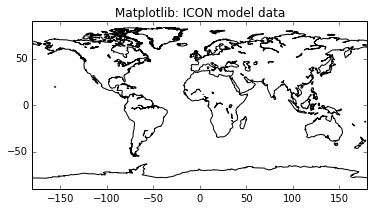

In [16]:
rad2deg = 45./np.arctan(1.)                         #-- radians to degrees

x, y        =  g.variables['clon'][:], g.variables['clat'][:]
vlon, vlat  =  g.variables['clon_vertices'][:], g.variables['clat_vertices'][:]

ncells, nv  =  vlon.shape[0], vlon.shape[1]         #-- number of cells and edges

#-- create figure and axes instances; we need subplots for plot and colorbar
fig, ax = plt.subplots()

#-- create basic map
map = Basemap(projection = 'cyl', lon_0 = 0., suppress_ticks = False)
map.drawcoastlines()  #-- draw coastlines, state and country boundaries, edge of map

plt.title(title) 

#-- convert latitude/longitude values into degrees
x, y               =  x*rad2deg, y*rad2deg          #-- cell center lon/lat
vlon_deg, vlat_deg =  vlon*rad2deg, vlat*rad2deg

#-- convert corrdinates of the triangles to 1D-arrays
vlon_1d, vlat_1d   = vlon_deg.ravel(), vlat_deg.ravel()

#-- rearrange the longitude values to -180.-180.
def rearrange(vlon_ar):
    less_than    = vlon_ar < -180.
    greater_than = vlon_ar >  180.
    vlon_ar[less_than]    = vlon_ar[less_than] + 360.
    vlon_ar[greater_than] = vlon_ar[greater_than] - 360.
    return vlon_ar

vlon_1d = rearrange(vlon_1d)                        #-- set longitude values to -180.-180. degrees

#-- convert latitude/longitude values to map x/y values
x0v, y0v = map(vlon_1d, vlat_1d)

#-- assign and set polygon array for polygons of type Nx2
xy = np.ndarray([ncells*nv,2],np.float32)
xy[:,0] = x0v
xy[:,1] = y0v

#-- print information to stdout
print ''
print 'Cell points:           ', nv
print 'Cells:                 ', str(ncells)
print 'Variable ta   min/max:  %.2f ' % np.min(var) + '/' + ' %.2f' % np.max(var)
print ''

Define color map and create array which contains the colors of the triangles.

In [17]:
cmap     = plt.get_cmap('Spectral_r', nlevs+1)              #-- read the color map
bounds   = range(varMin,varMax,varInt)                      #-- set bounds for color bar
bounds2  = [(varMin-varInt)] + bounds + [(varMax+varInt)]   #-- add color to the right and left
norm     = mpl.colors.BoundaryNorm(bounds, cmap.N)          #-- normalize for color bar
cmaplist = [i for i in range(cmap.N)]                       #-- color bar indices
ncol     = len(cmaplist)                                    #-- number of colors
colors   = np.ndarray([ncells+1,4],np.float32)              #-- assign color array for triangles
white    = [[1.,1.,1.,1.]]

print ''
print 'levels:           ',levels
print 'nlevs:            %3d' %nlevs
print 'ncols:            %3d' %ncol
print ''

#-- set color index of all cells in between levels
for m in xrange(0,nlevs):
    vind = []                                               #-- empty list for color indices
    for i in xrange(0,ncells-1):
        if (varM[i] >= levels[m] and varM[i] < levels[m+1]):
           colors[i,:] = cmap(cmaplist[m+1])
           vind.append(i) 
    print 'finished level %3d' % m , ' -- %5d ' % len(vind) , ' polygons considered'
    del vind

colors[np.where(varM < varMin),:]  = cmap(cmaplist[0])      #-- set color index for cells less than level[0]
colors[np.where(varM >= varMax),:] = cmap(cmaplist[ncol-1]) #-- set color index for cells greater than levels[nlevs-1]
colors[np.nonzero(varM.mask),:]    = white                  #-- set color index for missing values


levels:            [-32, -28, -24, -20, -16, -12, -8, -4, 0, 4, 8, 12, 16, 20, 24]
nlevs:             15
ncols:             16

finished level   0  --   402   polygons considered
finished level   1  --   583   polygons considered
finished level   2  --   447   polygons considered
finished level   3  --   515   polygons considered
finished level   4  --   713   polygons considered
finished level   5  --   952   polygons considered
finished level   6  --  1075   polygons considered
finished level   7  --  1303   polygons considered
finished level   8  --  1603   polygons considered
finished level   9  --  2184   polygons considered
finished level  10  --  2778   polygons considered
finished level  11  --  5378   polygons considered
finished level  12  --  1496   polygons considered
finished level  13  --    37   polygons considered
finished level  14  --     0   polygons considered


Create the polygons; take care of edge effects.

In [18]:
j = 0
icut = 0
icha = 0
for i in range(0,ncells-1):
    triangle =  xy[j:j+nv]

    edgesl   =  triangle[:,0] < -179.5
    edgesr   =  triangle[:,0] >  179.5
    
    if (sum(edgesl) == 2):
       triangle = np.where(triangle < -179.5, triangle + 360., triangle)
       icha = icha + 1
    if (sum(edgesr) == 2):
       triangle = np.where(triangle >  179.5, triangle - 360., triangle)
       icha = icha + 1

    negative =  triangle[:,0] < 0
    positive =  triangle[:,0] > 0
    center   = (triangle[:,0] > -180.) & (triangle[:,0] < 180.)

    if not (sum(negative) == 3 or sum(positive) == 3 or sum(center) == 3):
       icut = icut + 1
    else:
       polygon = Polygon(triangle, fc=colors[i,:], ec='black', closed=True, \
                         lw=0.3, ls='solid')
       #                  lw=0.3, ls='solid', aa=False, clip_on=True)
       ax.add_patch(polygon)
    j = j + nv

print ''
print '---> %5d' % icha + ' triangles longitude value + 360.'
print '---> %5d' % icut + ' triangles cut off'
print ''


--->    50 triangles longitude value + 360.
--->   196 triangles cut off



Add the colorbar (labelbar).

In [19]:
ax   = fig.add_axes([0.15, 0.15, 0.75, 0.03])               #-- l, b, w, h
cbar = mpl.colorbar.ColorbarBase(ax, cmap=cmap, norm=norm, spacing='proportional',\
                                 ticks=bounds, boundaries=bounds2, format='%3i', \
                                 orientation='horizontal')
cbar.set_label('deg C')                                     #-- add colorbar title string

Create the plot PNG file.

In [20]:
#-- create the plot
plt.show()
#plt.savefig('plot_unstructured_ICON_triangles.png', bbox_inches='tight')

Show plot below.

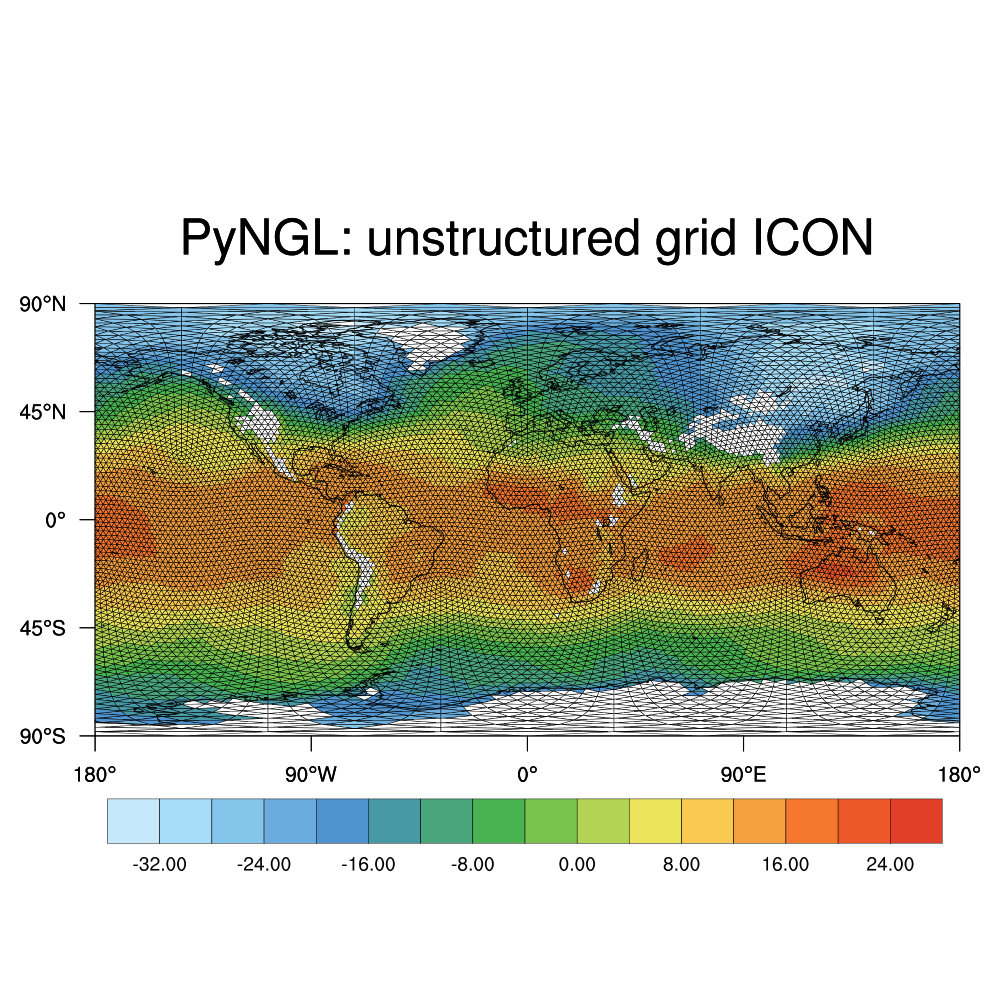

In [21]:
from IPython.display import Image
Image(filename='plot_unstructured_ICON_triangles.png') 